## __Import__

Bayern - Wolfsburg: 3890305
Hoffenheim - Schalke: 3890561

In [ ]:
from dataloader import Dataloader
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from collections import defaultdict


dataloader = Dataloader()

df = dataloader.get_dimension(dimension="shooting")
df.columns, df.shape

[2025-03-18 08:29:13] Loading data form local file system


(Index(['player', 'position', 'type', 'location', 'minute', 'shot_aerial_won',
        'play_pattern', 'shot_body_part', 'shot_end_location',
        'shot_first_time', 'shot_outcome', 'shot_statsbomb_xg',
        'shot_technique', 'shot_type', 'shot_follows_dribble', 'under_pressure',
        'match_id', 'possession_team'],
       dtype='object'),
 (7831, 18))

## __Setting types__

In [ ]:
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list) #shot_end_location
df["shot_end_location"] = df["shot_end_location"].apply(convert_to_list) #shot_end_location
df[["x", "y"]] = df["location"].apply(pd.Series)
df[["x_end_shot", "y_end_shot","z_end_shot"]] = df["shot_end_location"].apply(pd.Series)

df["under_pressure"] = df["under_pressure"] == True
df

,player,position,type,location,minute,shot_aerial_won,play_pattern,shot_body_part,shot_end_location,shot_first_time,...,shot_type,shot_follows_dribble,under_pressure,match_id,possession_team,x,y,x_end_shot,y_end_shot,z_end_shot
3692,Tarik Elyounoussi,Left Wing Back,Shot,"[108.1, 31.2]",4,<NA>,Regular Play,Left Foot,"[120.0, 35.2, 1.0]",True,...,Open Play,<NA>,<NA>,3890561,Hoffenheim,108.1,31.2,120.0,35.2,1.0
3693,Klaas-Jan Huntelaar,Center Forward,Shot,"[110.9, 42.6]",6,<NA>,From Throw In,Right Foot,"[120.0, 39.3, 0.5]",True,...,Open Play,<NA>,<NA>,3890561,Schalke 04,110.9,42.6,120.0,39.3,0.5
3694,Kevin Volland,Left Attacking Midfield,Shot,"[117.9, 29.1]",8,<NA>,From Throw In,Left Foot,"[118.1, 30.2]",True,...,Open Play,<NA>,True,3890561,Hoffenheim,117.9,29.1,118.1,30.2,NaN
3695,Jean-Eric Maxim Choupo-Moting,Left Midfield,Shot,"[101.8, 27.6]",13,<NA>,From Counter,Left Foot,"[120.0, 39.0, 0.2]",NaN,...,Open Play,<NA>,<NA>,3890561,Schalke 04,101.8,27.6,120.0,39.0,0.2
3696,Klaas-Jan Huntelaar,Center Forward,Shot,"[109.3, 26.5]",17,<NA>,Regular Play,Right Foot,"[118.8, 36.0, 0.2]",NaN,...,Open Play,<NA>,<NA>,3890561,Schalke 04,109.3,26.5,118.8,36.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069768,Thomas Müller,Right Center Midfield,Shot,"[113.6, 30.4]",72,<NA>,From Counter,Left Foot,"[120.0, 38.9, 0.2]",NaN,...,Open Play,<NA>,<NA>,3890259,Bayern Munich,113.6,30.4,120.0,38.9,0.2
1069769,David Olatukunbo Alaba,Left Back,Shot,"[99.2, 25.5]",77,<NA>,From Throw In,Left Foot,"[117.7, 36.8, 2.2]",NaN,...,Open Play,<NA>,<NA>,3890259,Bayern Munich,99.2,25.5,117.7,36.8,2.2
1069770,Douglas Costa de Souza,Right Midfield,Shot,"[106.5, 64.6]",83,<NA>,From Free Kick,Left Foot,"[120.0, 37.3, 3.6]",NaN,...,Open Play,<NA>,<NA>,3890259,Bayern Munich,106.5,64.6,120.0,37.3,3.6
1069771,Douglas Costa de Souza,Right Midfield,Shot,"[100.7, 57.0]",86,<NA>,From Goal Kick,Left Foot,"[120.0, 37.0, 0.7]",NaN,...,Open Play,<NA>,True,3890259,Bayern Munich,100.7,57.0,120.0,37.0,0.7


## __Generate Features__

In [9]:
def is_ex_in_goal_area(row):
    pitch_width = 120
    x = row["x"]
    y = row["y"]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def is_ex_in_penalty_area(row):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = row["x"]
    y = row["y"]

    if is_ex_in_goal_area(row):
        return False
    else:
        x_axis = ((102 <= x) and (x <= pitch_width))  
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_in_attacking_third(row):
    pitch_width = 120
    x = row["x"]

    if is_ex_in_goal_area(row) or is_ex_in_penalty_area(row):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_middle_third(row):
    #print("Executing is_in_middle_third method")
    pitch_width = 120
    x = row["x"]

    return (1 * (pitch_width / 3)) <= x <= (2 * (pitch_width / 3))

def calculate_distance(row):
    return np.linalg.norm(np.array([row["x"], row["y"]]) - np.array([row["x_end_shot"], row["y_end_shot"]])) 

def count_important_goals(df):
    results = defaultdict(list)

    for match_id in df["match_id"].unique():
        match = df.loc[df["match_id"] == match_id, ["match_id", "player","minute","possession_team"]]
        match = match.sort_values("minute", ascending=True)
        team_names = match['possession_team'].unique()
        team_scores = {team: 0 for team in team_names}
        is_equalized=False

        for i in range(match.shape[0]):
            team_scores[match.iloc[i]["possession_team"]]  += 1
            scores = list(team_scores.values())
            
            # first goal
            if (sum(scores) == 1):
                results[match.iloc[i]["player"]].append("first_goal")
            # equalizer
            elif (len(scores) > 1) and (scores[0] == scores[1]):
                is_equalized=True
                results[match.iloc[i]["player"]].append("equalizer")
            # taking the lead
            elif (len(scores) > 1) and (scores[0]>scores[1] or scores[1]>scores[0]) and is_equalized:
                is_equalized=False
                results[match.iloc[i]["player"]].append("leading_goal")
    # TODO:  Not correct yet 
    df_results = pd.DataFrame([
        {"player": player, "event": event}
        for player, events in results.items()
        for event in events
    ])

    df_event_counts = df_results.groupby(["player", "event"]).size().unstack(fill_value=0).reset_index()
    return df_event_counts

# Create player statistics
def analyze_shooting(df):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # tresholds
    long_goal_min_distance = 20
    short_goal_max_distance = 10
    treshold_xG = 0.3
    treshold_dist = 11
    threshold_last_minute_goal = 85

    # Pre-compute all conditions
    df_with_flags = df.copy()

    # action flags
    df_with_flags["is_goal"] = df["shot_outcome"] == "Goal"
    df_with_flags["is_shot"] = df["type"] == "Shot"
    df_with_flags["is_penalty"] = df["shot_type"] == "Penalty"
    df_with_flags["is_freekick"] = df["shot_type"] == "Free Kick"
    df_with_flags["is_left_foot"] = df["shot_body_part"] == "Left Foot"
    df_with_flags["is_right_foot"] = df["shot_body_part"] == "Right Foot"
    df_with_flags["is_head"] = df["shot_body_part"] == "Head"
    df_with_flags["is_other_part"] = df["shot_body_part"] == "Other"
    df_with_flags["is_first_touch"] = df["shot_first_time"] == True

    # location flags
    df_with_flags["is_in_goal_area"] = df[["x","y"]].apply(is_ex_in_goal_area, axis=1)
    df_with_flags["is_in_penalty_area"] = df[["x","y"]].apply(is_ex_in_penalty_area, axis=1)
    df_with_flags["is_in_attacking_third"] = df[["x","y"]].apply(is_ex_in_attacking_third, axis=1)
    df_with_flags["is_in_middle_third"] = df[["x","y"]].apply(is_in_middle_third, axis=1)
    df_with_flags["goal-shot_distance"] = df[["x","y","x_end_shot","y_end_shot"]].apply(calculate_distance, axis=1)
    df_with_flags["is_long_distance"] = (df_with_flags["goal-shot_distance"] >= long_goal_min_distance) 
    df_with_flags["is_short_distance"] = (df_with_flags["goal-shot_distance"] <= short_goal_max_distance) 
    df_with_flags["is_mid_distance"] = ~df_with_flags["is_short_distance"] & ~df_with_flags["is_long_distance"]

    # combinations
    df_with_flags["penalty_goal"] = (df_with_flags["is_penalty"]) & (df_with_flags["is_goal"])
    df_with_flags["shot_on_target"] = (df["shot_outcome"] != "Off T") & (df["shot_outcome"] != "Wayward") & (df["shot_outcome"] != "Saved Off T")
    df_with_flags["shot_on_target_left_foot"] = df_with_flags["is_left_foot"] & df_with_flags["shot_on_target"]
    df_with_flags["shot_on_target_right_foot"] = df_with_flags["is_right_foot"] & df_with_flags["shot_on_target"]
    df_with_flags["goal_left_foot"] = df_with_flags["is_left_foot"] & df_with_flags["is_goal"]
    df_with_flags["goal_right_foot"] = df_with_flags["is_right_foot"] & df_with_flags["is_goal"]
    df_with_flags["goal_with_head"] = df_with_flags["is_head"] & df_with_flags["is_goal"]
    df_with_flags["goal_with_other_part"] = df_with_flags["is_other_part"] & df_with_flags["is_goal"]
    df_with_flags["goal_with_first_touch"] = df_with_flags["is_first_touch"] & df_with_flags["is_goal"]
    df_with_flags["goal_in_goal_area"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_goal"]
    df_with_flags["goal_in_penalty_area"] = df_with_flags["is_in_penalty_area"] & df_with_flags["is_goal"]
    df_with_flags["goal_in_attacking_third"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_goal"]
    df_with_flags["goal_in_middle_third"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_goal"]
    df_with_flags["goal_is_long_distance"] = df_with_flags["is_long_distance"] & df_with_flags["is_goal"]
    df_with_flags["goal_is_mid_distance"] = df_with_flags["is_mid_distance"] & df_with_flags["is_goal"]
    df_with_flags["goal_is_short_distance"] = df_with_flags["is_short_distance"] & df_with_flags["is_goal"]
    df_with_flags["shot_with_first_touch"] = df_with_flags["is_first_touch"] & df_with_flags["is_shot"]
    df_with_flags["shot_in_goal_area"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_shot"]
    df_with_flags["shot_in_penalty_area"] = df_with_flags["is_in_penalty_area"] & df_with_flags["is_shot"]
    df_with_flags["shot_in_attacking_third"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_shot"]
    df_with_flags["shot_in_middle_third"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_shot"]
    df_with_flags["shot_is_long_distance"] = df_with_flags["is_long_distance"] & df_with_flags["is_shot"]
    df_with_flags["shot_is_mid_distance"] = df_with_flags["is_mid_distance"] & df_with_flags["is_shot"]
    df_with_flags["shot_is_short_distance"] = df_with_flags["is_short_distance"] & df_with_flags["is_shot"]
    df_with_flags["goal_normal"] = (df["shot_technique"] == "Normal") & (df_with_flags["is_goal"])
    df_with_flags["goal_volley"] = (df["shot_technique"] == "Volley") & (df_with_flags["is_goal"])
    df_with_flags["goal_half_volley"] = (df["shot_technique"] == "Half Volley") & (df_with_flags["is_goal"])
    df_with_flags["goal_lob"] = (df["shot_technique"] == "Lob") & (df_with_flags["is_goal"])
    df_with_flags["goal_backheel"] = (df["shot_technique"] == "Backheel") & (df_with_flags["is_goal"])
    df_with_flags["goal_overhead_kick"] = (df["shot_technique"] == "Overhead Kick") & (df_with_flags["is_goal"])
    df_with_flags["goal_diving_header"] =(df["shot_technique"] == "Diving Header") & (df_with_flags["is_goal"])
    df_with_flags["is_big_chance"] =(df["shot_statsbomb_xg"] >= treshold_xG) & (df_with_flags["goal-shot_distance"] <= treshold_dist)
    df_with_flags["is_big_chance_led_to_goal"] =(df["shot_statsbomb_xg"] >= treshold_xG) & (df_with_flags["goal-shot_distance"] <= treshold_dist) & (df_with_flags["is_goal"])
    df_with_flags["goal_inside_penalty_area"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_in_penalty_area"] & df_with_flags["is_goal"]
    df_with_flags["goal_outside_penalty_area"] = ~df_with_flags["goal_inside_penalty_area"]
    df_with_flags["shot_inside_penalty_area"] = df_with_flags["is_in_goal_area"] & df_with_flags["is_in_penalty_area"] & df_with_flags["is_shot"]
    df_with_flags["shot_outside_penalty_area"] = ~df_with_flags["shot_inside_penalty_area"]
    df_with_flags["is_last_minute_goal"] = (df["minute"] >= threshold_last_minute_goal) & (df_with_flags["is_goal"])


    player_under_pressure_grouping = df_with_flags.groupby(['player',"under_pressure"]).agg(
        # goals 
        goals=('is_goal', "sum"),
        goals_penalty=("penalty_goal","sum"),
        goals_header=('goal_with_head', "sum"),
        goals_left_foot=('goal_left_foot', "sum"),
        goals_right_foot=('goal_right_foot', "sum"),
        goals_other_body_part=('goal_with_other_part', "sum"),
        goals_with_first_touch=('goal_with_first_touch', "sum"),
        goals_in_goal_area=("goal_in_goal_area", "sum"),
        goals_in_penalty_area=("goal_in_penalty_area", "sum"),
        goals_in_attacking_third=("goal_in_attacking_third", "sum"),
        goals_in_middle_third=("goal_in_middle_third", "sum"),
        goals_inside_penalty_area=("goal_inside_penalty_area","sum"),
        goals_outside_penalty_area=("goal_outside_penalty_area","sum"),
        goals_long_distance=("goal_is_long_distance","sum"),
        goals_mid_distance=("goal_is_mid_distance","sum"),
        goals_short_distance=("goal_is_short_distance","sum"),
        goals_avg_distance=("goal-shot_distance", lambda x: x[df_with_flags["is_goal"]==True].mean()),
        # shots
        shots_total=('player', "count"),
        shots_on_target=("shot_on_target","sum"),
        shots_from_freekick = ('is_freekick', "sum"),
        shots_from_penalty = ('is_penalty', "sum"),
        shots_on_target_left_foot = ("shot_on_target_left_foot", "sum"),
        shots_on_target_right_foot = ("shot_on_target_right_foot", "sum"),
        shots_with_first_touch=('shot_with_first_touch', "sum"),
        shots_in_goal_area=("shot_in_goal_area", "sum"),
        shots_in_penalty_area=("shot_in_penalty_area", "sum"),
        shots_in_attacking_third=("shot_in_attacking_third", "sum"),
        shots_in_middle_third=("shot_in_middle_third", "sum"),
        shots_inside_penalty_area=("shot_inside_penalty_area","sum"),
        shots_outside_penalty_area=("shot_outside_penalty_area","sum"),
        shots_long_distance=("shot_is_long_distance","sum"),
        shots_mid_distance=("shot_is_mid_distance","sum"),
        shots_short_distance=("shot_is_short_distance","sum"),
        shots_avg_distance=("goal-shot_distance", lambda x: x[df_with_flags["is_shot"]==True].mean()),
        # goal techniques
        goal_normal=("goal_normal", "sum"),
        goal_volley=("goal_volley", "sum"),
        goal_half_volley=("goal_half_volley", "sum"),
        goal_lob=("goal_lob", "sum"),
        goal_backheel=("goal_backheel", "sum"),
        goal_overhead_kick=("goal_overhead_kick","sum"),
        goal_diving_header=("goal_diving_header", "sum"),
        # big chances and important goals
        xG=("shot_statsbomb_xg", "sum"),
        big_chances_total=("is_big_chance","sum"),
        big_chances_led_to_goal=("is_big_chance_led_to_goal","sum"),
        last_minute_goals=("is_last_minute_goal","sum")

    )

    total_stats = player_under_pressure_grouping.groupby('player').sum()

    player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
    player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
    player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
    player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

    important_goal_counts = count_important_goals(df)

    player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")
    player_stats = pd.merge(left=player_stats, right=important_goal_counts, on="player")

    calculation_pairs = [
        ('shots_on_target', 'shots_total', "shots_on_target_%"),
        ("goals", "shots_total", "shot_conversion_%"),
        ("goals", "shots_on_target", "shot_conversion_on_target_%"),
        ("up_goals", "up_shots_total", "up_shot_conversion_%"),
        ("up_shots_on_target", "up_shots_total", "up_shots_on_target_%"),
        ("shots_inside_penalty_area", "shots_total", "shots_inside_the_box_%"),
        ("shots_outside_penalty_area", "shots_total", "shots_outside_the_box_%"),
        ("goals_right_foot", "goals", "goals_right_foot_%"),
        ("goals_left_foot", "goals", "goals_left_foot_%"),
        ("goals_with_first_touch", "goals", "goals_with_first_touch_%"),
        ("big_chances_led_to_goal", "big_chances_total","big_chance_conversion_%"),
        ("goals_outside_penalty_area", "goals","goals_outside_penalty_area_%"),
        ("goals_inside_penalty_area", "goals","goals_inside_penalty_area_%"),
        ("goals_header", "goals", "goals_header_%")
    ]
    
    for a, b, c in calculation_pairs:
        player_stats[c] = (player_stats[f'{a}'] / player_stats[f'{b}']).round(3)


    return player_stats

result_df=analyze_shooting(df)
result_df

,player,goals,goals_penalty,goals_header,goals_left_foot,goals_right_foot,goals_other_body_part,goals_with_first_touch,goals_in_goal_area,goals_in_penalty_area,...,up_shots_on_target_%,shots_inside_the_box_%,shots_outside_the_box_%,goals_right_foot_%,goals_left_foot_%,goals_with_first_touch_%,big_chance_conversion_%,goals_outside_penalty_area_%,goals_inside_penalty_area_%,goals_header_%
0,Aaron Hunt,0,0,0,0,0,0,0,0,0,...,0.750,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
1,Adelino André Vieira Freitas,0,0,0,0,0,0,0,0,0,...,0.500,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
2,Admir Mehmedi,2,0,0,0,2,0,0,0,2,...,0.714,0.0,1.0,1.0,0.0,0.0,NaN,3.5,0.0,0.0
3,Albin Ekdal,0,0,0,0,0,0,0,0,0,...,0.333,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
4,Alejandro Gálvez Jimena,0,0,0,0,0,0,0,0,0,...,0.000,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Ádám Szalai,0,0,0,0,0,0,0,0,0,...,0.300,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
299,Änis Ben-Hatira,0,0,0,0,0,0,0,0,0,...,0.600,0.0,1.0,NaN,NaN,NaN,0.0,inf,NaN,NaN
300,Ömer Toprak,0,0,0,0,0,0,0,0,0,...,0.400,0.0,1.0,NaN,NaN,NaN,NaN,inf,NaN,NaN
301,İlkay Gündoğan,0,0,0,0,0,0,0,0,0,...,0.667,0.0,1.0,NaN,NaN,NaN,0.0,inf,NaN,NaN


## __Feature Selection__

In [16]:
columns_to_keep = ["player", "goals", "goals_penalty", "shots_total",'shots_on_target',"shots_avg_distance", 'shots_in_penalty_area',
                    'shots_in_goal_area', 'shots_in_attacking_third', 'shots_long_distance', 'shots_mid_distance',
                    'shots_short_distance','goal_volley',"goals_avg_distance", 
                    'goal_half_volley', 'goal_normal',"goals_header" ,"goals_header_%",'shots_on_target_%',
                    'shot_conversion_%', 'shot_conversion_on_target_%',
                    'up_shot_conversion_%', 'up_shots_on_target_%',
                    'shots_inside_the_box_%', 'shots_outside_the_box_%',
                    'goals_right_foot_%', 'goals_left_foot_%',
                    'goals_with_first_touch_%',"big_chance_conversion_%", "goals_outside_penalty_area_%","goals_inside_penalty_area_%"
        ]

result_df = result_df[columns_to_keep]

## __Store data__

In [17]:
result_df.to_csv("../data/shooting.csv",index=False)

## __Visualize all Shot Attempts__

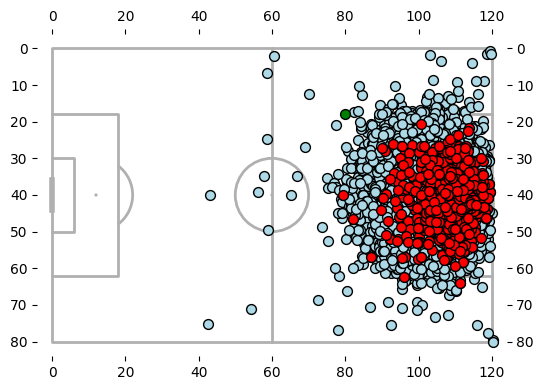

In [ ]:
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

ax.scatter(df["x"], df["y"], c='lightblue', s=50, edgecolors='black', zorder=5)
ax.scatter(df.loc[df['shot_outcome'] == 'Goal',"x"], df.loc[df['shot_outcome'] == 'Goal',"y"], c='red', s=50, edgecolors='black', zorder=5)
ax.scatter(2 * (120/3) , (40- 22), c='green', s=50, edgecolors='black', zorder=5)
plt.show()

### __Scaling Coordinates__

__original__

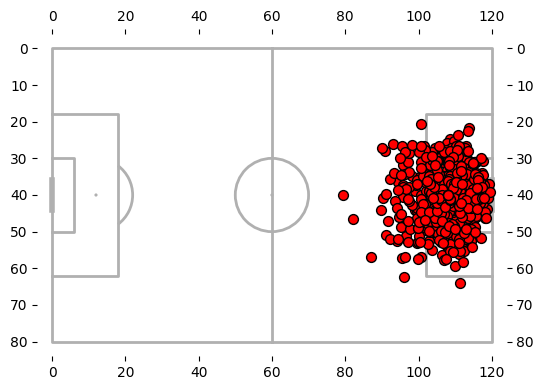

In [ ]:
goals = np.vstack([shot for shot in df[df['shot_outcome'] == 'Goal']['location']])
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))
ax.scatter(goals[:, 0], goals[:, 1], c='red', s=50, edgecolors='black', zorder=5)
plt.show()

__Bundeslga Size 105m x 68m__

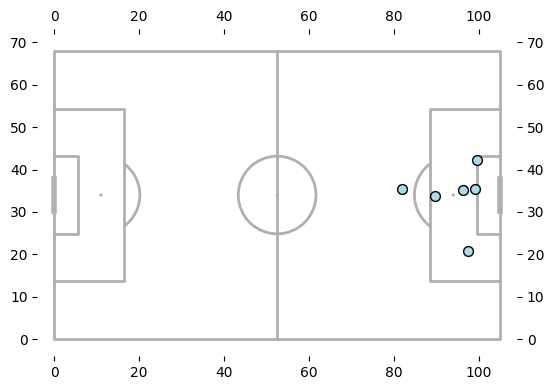

In [ ]:
from mplsoccer import Standardizer

statsbomb_to_bundesliga = Standardizer(pitch_from='statsbomb', pitch_to='custom', length_to=105, width_to=68)
x, y = statsbomb_to_bundesliga.transform(goals[:,0], goals[:,1])

bundesliga_pitch = Pitch(pitch_type="custom", pitch_length=105,pitch_width=68 ,label=True, tick=True)
fig, ax = bundesliga_pitch.draw(figsize=(8, 4))
ax.scatter(x, y, c='lightblue', s=50, edgecolors='black', zorder=5)
plt.show()